# Comparing Chl between SeaWIFS and CESM-LE Output
1. load data


In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict

import calendar
import numpy as np
import xarray as xr
import xesmf as xe
import dask
from ncar_jobqueue import NCARCluster
import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import util
import shutil

In [2]:
pwd = os.getcwd()
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks'

In [3]:
'''
Ran once to create Zarr file from:

SeaWiFS data on the POP grid: along with the original data I interpolated from
is in /glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data. 
The notebook that does the interpolation is 
https://github.com/mnlevy1981/cesm2-marbl/blob/
interpolate_chl_data/notebooks/chl_regrid/map%20chl%20to%20gx1v7.ipynb 
and the mapping file (the only part generated outside of python) is 
/glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/
weights/seaWIFS_to_POP_gx1v7_conservative.nc
'''
'''
#load Seawifs Data
seawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'

dsi = xr.open_dataset(seawifs_pop_file, decode_coords=False, decode_times=False, 
                            chunks={'nlon': 16})

file_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'
if os.path.exists(file_out):
    shutil.rmtree(file_out)
dsi.to_zarr(file_out);
'''

"\n#load Seawifs Data\nseawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'\n\ndsi = xr.open_dataset(seawifs_pop_file, decode_coords=False, decode_times=False, \n                            chunks={'nlon': 16})\n\nfile_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'\nif os.path.exists(file_out):\n    shutil.rmtree(file_out)\ndsi.to_zarr(file_out);\n"

In [4]:
#Load Model Output from Compressed File processed in cesm-initial-look script
dsmod = xr.open_zarr('data/cesm-le-sst-chl.zarr').compute()
#dsmod2 = xr.open_zarr('data/cesm-le-sst-chl-97-10.zarr').compute()
#Load Observational Data from Compressed File processed in Seawifs script
dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr').compute()
#dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seawifs_L3m_MC_GSM_chl_gsm_9km_global.zarr').compute()

## Notes on Data:
    
SeaWiFS Climatology is:
* Sept (1997 - 2010)
* Oct (1997 - 2010)
* Nov (1997 - 2010)
* Dec (1997 - 2010)
* Jan (1998 - 2010)
* Feb (1998 - 2010)
* March (1998 - 2010)
* April (1998 - 2010)
* May (1998 - 2010)
* June (1998 - 2010)
* July (1998 - 2010)
* Aug (1998 - 2010)

In [5]:
#make month variables match:
dsmod['month'] = dsobs['month']
dsobs['z_t'] = dsmod['z_t']
dsobs['z_t_150m'] = dsmod['z_t_150m']

### Compare the differences in the data formats:

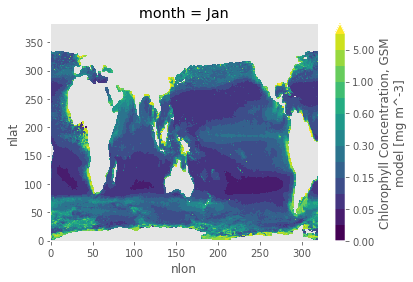

In [6]:
#plot Observational Data:
levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]
dsobs.chl_gsm.sel(month='Jan').plot(levels = levels);

obs data shape: (12, 384, 320) model data shape: (12, 384, 320)


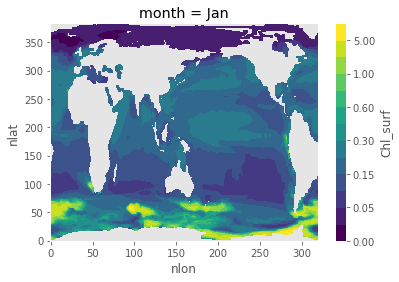

In [7]:
#plot CESM:
levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]
dsmod.Chl_surf.sel(month='Jan').plot(levels = levels);
print('obs data shape:', dsobs.chl_gsm.shape, 'model data shape:', dsmod.Chl_surf.shape)

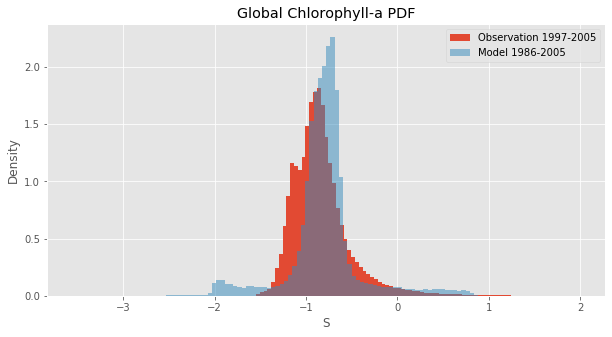

In [8]:
#Log transform the data
mod_log_trans = np.log10(dsmod.Chl_surf.where(dsmod.Chl_surf>0))
obs_log_trans = np.log10(dsobs.chl_gsm.where(dsobs.chl_gsm>0))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Observation 1997-2005');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.xlabel('S')
plt.title('Global Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('Global-Chl_seawifs-v-cesm.png')

## Compare within Southern Ocean

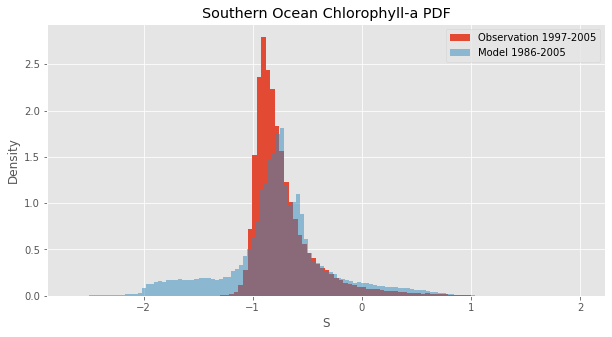

In [9]:
#Subset to Southern Ocean
ds_ob_so = dsobs.where(dsobs.TLAT <= -45)
ds_mod_so = dsmod.where(dsmod.TLAT <= -45)
#Log transform the data
mod_log_trans = np.log10(ds_mod_so.Chl_surf.where(ds_mod_so.Chl_surf>0 & (ds_mod_so.TLAT <= -45)))
obs_log_trans = np.log10(ds_ob_so.chl_gsm.where(ds_ob_so.chl_gsm>0 & (ds_ob_so.TLAT <= -45)))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Observation 1997-2005');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.xlabel('S')
plt.title('Southern Ocean Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('SouthernOcean-Chl_seawifs-v-cesm.png')

## Map out a month

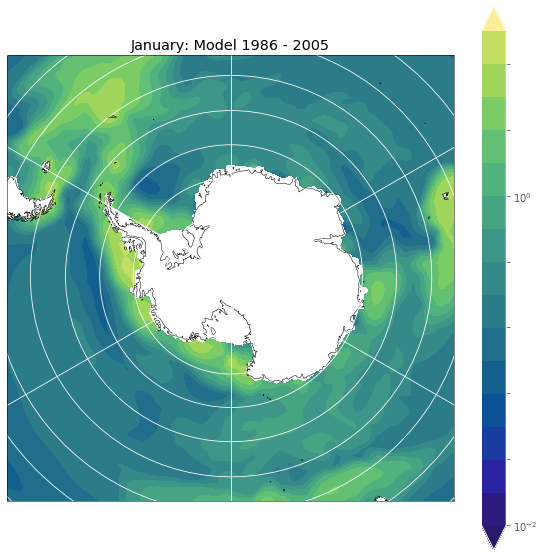

In [10]:
#PLOT IT
dsp = util.pop_add_cyclic(dsmod)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 100)), dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.Chl_surf.isel(month=0, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Model 1986 - 2005')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)
#plt.savefig('January-CESM-Chl-map.png')

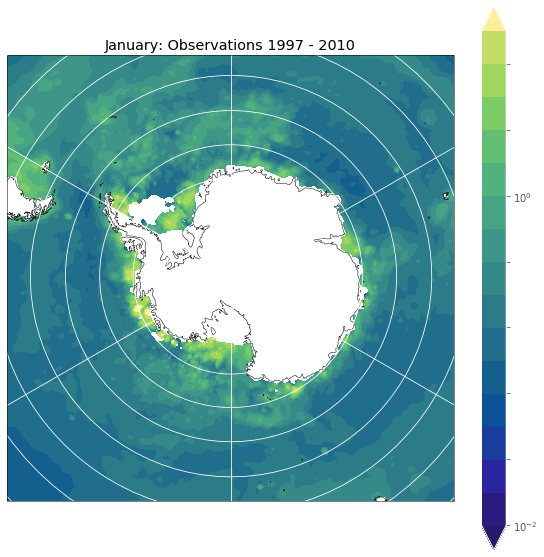

In [58]:
#PLOT IT
dsp = util.pop_add_cyclic(dsobs)

#Data:
lon = dsp.TLONG.isel(nlat=slice(0, 100))
lat = dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.chl_gsm.isel(month=0, nlat=slice(0, 100))

#Set up Figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
norm = colors.LogNorm(vmin=0.01, vmax=20.)
levels = np.logspace(-2, 1, 16)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Observations 1997 - 2010')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)
#plt.savefig('January-seawifs-POPGRID-Chl-map.png')

## Monthly Maps

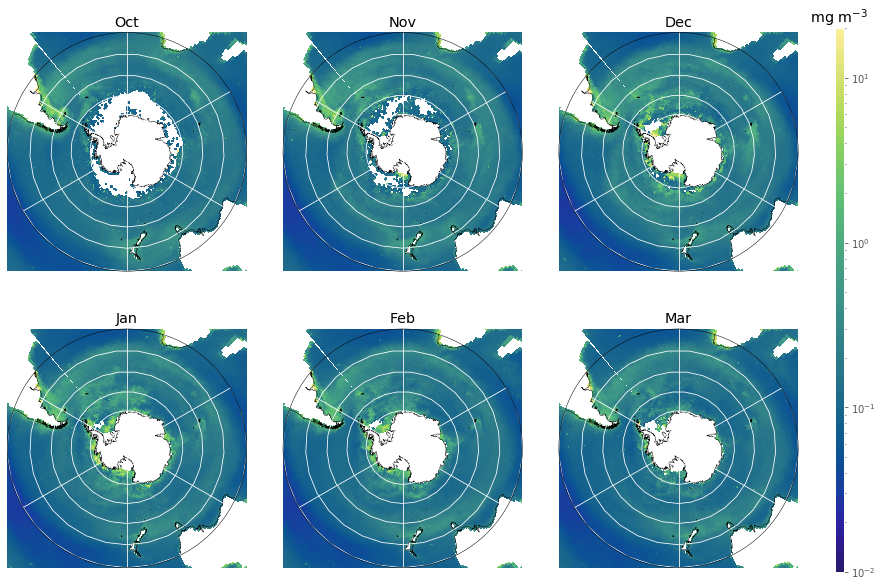

In [20]:
dsp = util.pop_add_cyclic(dsobs)

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsobs.TLAT.values
lon = dsobs.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsobs.chl_gsm.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('mg m$^{-3}$');

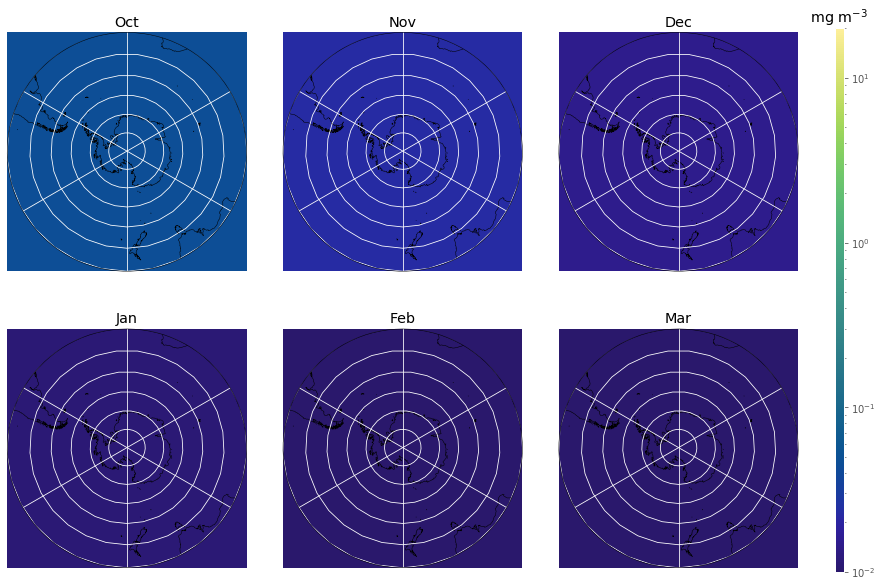

In [21]:
dsp = util.pop_add_cyclic(dsmod)

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsmod.TLAT.values
lon = dsmod.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsmod.Chl_surf.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('mg m$^{-3}$');

# REGIONALIZE
one option: Kristen's Example Use of POP-TOOLS for regions and weighted means
* https://github.com/kristenkrumhardt/CESM2_oceanBGC_diag/blob/0081fd9817c517f6f71d4d443389338cc06b2d80/nutsO2_diagnostics_003-iaf2.ipynb
other option: Riley's simple masks

#### SET-UP

In [24]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)

In [25]:
lat = grid.TLAT
lon = grid.TLONG

In [26]:
mask_SO_atl = (lat <= -44) & ((lon >= 298) | (lon <= 20))
mask_SO_ind = (lat <= -44) & (lon > 20) & (lon <= 145)
mask_SO_pac = (lat <= -44) & (lon > 145) & (lon <= 298)
mask_SO = (lat <= -44)
#Test it
#dsobs.chl_gsm.where(mask_SO_pac).sel(month='Jan').plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20])
#dsobs.chl_gsm.where(mask_SO_atl).sel(month='Jan').plot()

In [27]:
# Create regional weighted means
#Pacific - CESM
ds_pac = dsmod.Chl_surf.where(mask_SO_pac)
ds_pac['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*dsmod.TAREA.where(mask_SO_pac),
                                         weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()
#Pacific - Observations
ds_pac_obs = dsobs.chl_gsm.where(mask_SO_pac)
ds_pac_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*dsobs.TAREA.where(mask_SO_pac),
                                         weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()
#Atlantic - CESM
ds_atl = dsmod.Chl_surf.where(mask_SO_atl)
ds_atl['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*dsmod.TAREA.where(mask_SO_atl),
                                         weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()
#Atlantic - Observations
ds_atl_obs = dsobs.chl_gsm.where(mask_SO_atl)
ds_atl_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*dsobs.TAREA.where(mask_SO_atl),
                                         weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()
#Indian - CESM
ds_ind = dsmod.Chl_surf.where(mask_SO_ind)
ds_ind['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*dsmod.TAREA.where(mask_SO_ind),
                                         weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()
#Indian - Observations
ds_ind_obs = dsobs.chl_gsm.where(mask_SO_ind)
ds_ind_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*dsobs.TAREA.where(mask_SO_ind),
                                         weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()
#SOUTHERN OCEAN - CESM
ds_so = dsmod.Chl_surf.where(mask_SO)
ds_so['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*dsmod.TAREA.where(mask_SO),
                                         weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()
#SOUTHERN OCEAN - Observations
ds_so_obs = dsobs.chl_gsm.where(mask_SO)
ds_so_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*dsobs.TAREA.where(mask_SO),
                                         weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

In [28]:
#for saving figures:
#os.chdir('/glade/u/home/zephyrs/projects/krill-cesm-le/figures')
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks'

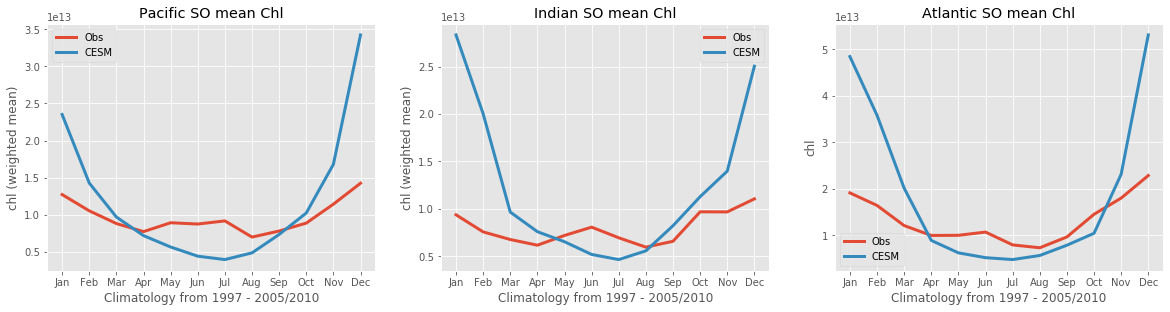

In [29]:
# Plot all Basins
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific SO mean Chl')
ax.plot(ds_pac_obs['month'].values, ds_pac_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_pac['month'].values, ds_pac['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca()

ax = fig.add_subplot(2,3,2)
ax.set_title('Indian SO mean Chl')
ax.plot(ds_ind_obs['month'].values, ds_ind_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_ind['month'].values, ds_ind['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca()

ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic SO mean Chl')
ax.plot(ds_atl_obs['month'].values, ds_atl_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_atl['month'].values, ds_atl['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl',xlabel='Climatology from 1997 - 2005/2010')
plt.gca()
#plt.savefig('chl-popgrid-regional-monthly-weighted-means.png')

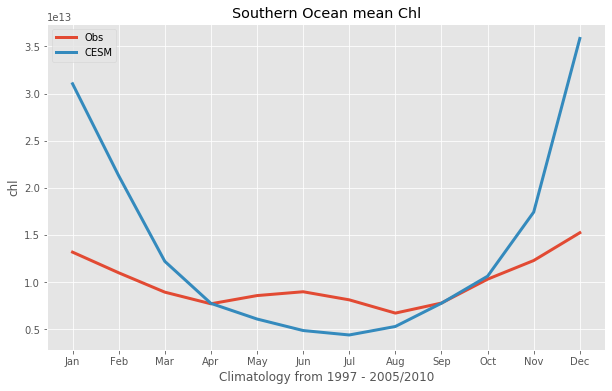

In [16]:
#Plot Southern Ocean as a whole:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Southern Ocean mean Chl')
ax.plot(ds_so_obs['month'].values, ds_so_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_so['month'].values, ds_so['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl',xlabel='Climatology from 1997 - 2005/2010')
plt.gca()
#plt.savefig('chl-popgrid-southern-ocean-monthly-weighted-mean.png')

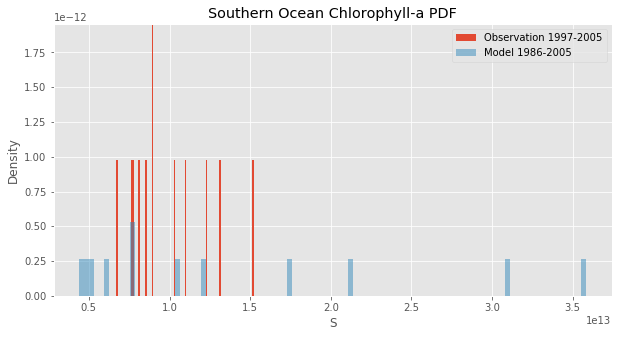

In [22]:
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(ds_so_obs.chl_gsm, 100, density=True, label='Observation 1997-2005');
plt.hist(ds_so.Chl_surf, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.xlabel('S')
plt.title('Southern Ocean Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig('SouthernOcean-Chl_seawifs-v-cesm.png')